# Working with `.POST` files on Windows

Summary of motivation:
- `.POST` files for our data are approx. 5MB, which is 1/10 the size of an equivalent H5 file.
- 10k timesteps may be enough, so that leaves approx 50GB per case if we were to save each post file.

Important info:
- This notebook uses files stored on local drive `Tr=1.1` as we have run ANSYS to produce post files for this case starting from timestep 2001 - it skipped this timestep so produced files from 2002. 
- ANSYS also produced a cas.post file.
- This was run using VisualStudio's internal Python 3.11 environment. Internal Terminal had to be used to install h5py, numpy, scipy and matplotlib.

After running this:
- The initial goal was to use The CellX, CellY outputs from the original cas.h5 file and map them to the temperature obtained from the post file. However the shape produced from regular h5 does not equal the number of results obtained form the post: 234480 for the original vs 235616 from post. 
- The next goal was to take the cell centroid coordinates from the post.cas instead using the same structure.
    - The original path is `/meshes/1/faces/nodes/...` but in post, there MUST be a `.post` following 1, i.e. `/meshes/1.post/faces/nodes/`
    - The original H5 group `/meshes/1/faces/` has 4 children: c0, c1, nodes and zoneTopology. The post equivalent, `/meshes/1.post/faces/`, only has 2: nodes and zoneTopology.
    - Therefore, the same method to map `FaceIdToCellId = np.array(f['/meshes/1/faces/c0/1'][:])  # Shape (M/2,)` will not work using post. 

Goals:
- Find a way to get cell centroid coordinates using casefile produced by post

In [18]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Define the data folder - must include .h5 cas and dat files.
DataFolder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"

#from cmcrameri import cm

In [7]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.02
YMAX    = 0.08
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]

In [20]:
# Print original casefiles from h5
casefiles = [f for f in os.listdir(DataFolder) if f.endswith('.cas.h5')]
print(casefiles)

['M4-1.cas.h5']


In [80]:
# Function to get cell centroid coordinates from h5 casefiles. 
def get_cells_from_cas(casefile):
    """Obtains cell centroid coordinates from a casefile. 
    Takes vertex indices, maps vertices to faces, and maps faces to cells. 
    Cell centroids are obtained and one zval is ascribed to one cell centroid.
    """
    fname = os.path.join(DataFolder, casefile)

    with h5py.File(fname, 'r') as f:
        VertexList = f['/meshes/1/nodes/coords/1'][:].T  # Shape should be (2, N)
        FaceIdToVertexId = f['/meshes/1/faces/nodes/1/nodes'][:]  # Shape (M,)
        FaceIdToCellId = np.array(f['/meshes/1/faces/c0/1'][:])  # Shape (M/2,)

        print(f['/meshes/1/faces/'])
    # take a cell==face, look at the edges, and then the vertices that make up the edge, then access
    # each coordinate 
    # 1 cell has 4 edges, each with 2 vertices, so overall 1 cell has 8 rows; 
    
    # Reshape VertexList based on FaceIdToVertexId (adjusting to 0-based index)
    vertex_indices = FaceIdToVertexId - 1  # Convert to 0-based index
    vertex_coords_x = VertexList[0, vertex_indices]
    vertex_coords_y = VertexList[1, vertex_indices]

    # Reshape into pairs of vertices for each face
    vertex_coords_x = vertex_coords_x.reshape((2, -1), order='F')
    vertex_coords_y = vertex_coords_y.reshape((2, -1), order='F')

    # Compute face centers
    # the face center is the average of the x and y vertex coords of the current cell, acc to cell ID.
    face_centers_x = np.mean(vertex_coords_x, axis=0)
    face_centers_y = np.mean(vertex_coords_y, axis=0)

    # Initialize cell centroids
    num_cells = np.max(FaceIdToCellId)
    CellX = np.zeros(num_cells)
    CellY = np.zeros(num_cells)
    counts = np.zeros(num_cells, dtype=int)

    # Aggregate face centers to compute cell centroids
    for i in range(len(FaceIdToCellId)):
        cell_id = FaceIdToCellId[i] - 1  # Adjust to 0-based index
        CellX[cell_id] += face_centers_x[i]
        CellY[cell_id] += face_centers_y[i]
        counts[cell_id] += 1

    # Compute centroids by dividing by the counts
    CellX /= counts
    CellY /= counts

    return CellX, CellY

In [ ]:
# Get h5 cell centroids
casefile = casefiles[0]
CellX, CellY = get_cells_from_cas(casefile)

In [81]:
# Function to map z value to h5 cell centroids
def get_xyz(CellX, CellY, datafile):
    """Maps cell centroid coordinates to zvalues from a datafile. 
    """
    fname = os.path.join(DataFolder, datafile)
    
    with h5py.File(fname, 'r') as f:
        T = f['/results/1/phase-1/cells/SV_T/1'][:]
        return T
    
# Function to do linear interpolation for plotting with h5 files.
def get_interpolated_contour(CellX, CellY, datafile):
    """Map cell centroid coordinates to zvalues from a datafile.
    Interpolates the cell centers + associated z value to a uniform grid
    for plotting purposes.
    """
    fname = os.path.join(DataFolder, datafile)
    
    Z = get_xyz(CellX, CellY, fname)
    
    # DOMAIN PARAMETERS - only for plotting purposes.
    Ypixels = 1080
    XMIN    = -0.25
    XMAX    = 0.25
    YMIN    = -0.02
    YMAX    = 0.08
    AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
    Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
    Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
    [xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
    Clim = [300, 310]

    if len(CellX) == len(CellY) == len(Z):
        from scipy.interpolate import griddata
        SI = griddata((CellX, CellY), Z, (xgrid, ygrid), method='linear', fill_value=np.nan)
        return SI
    else:
        raise ValueError("Lengths of CellX, CellY, and T do not match!")

# Function to query a point closest to a selected coordinate among the entire (CellX, Celly, z) set. 
def query_point(CellX, CellY, z, query_x, query_y):
    """Given a set of cell coords CellX, CellY, and a requested coordinate index,
    obtain the corresponding z value from the entire z array. 
    
    """
    tolerance = 1e-4
    rtol=1e-7
    new_index = np.where(np.isclose(CellX, query_x, atol=tolerance, rtol=rtol) & np.isclose(CellY, query_y, atol=tolerance, rtol=rtol))
    
    return new_index, z[new_index]

<HDF5 group "/meshes/1/faces" (4 members)>


In [23]:
# Read result h5 files
datafiles = [f for f in os.listdir(DataFolder) if f.endswith('dat.h5')]

# Perform sample interpolation
SI = get_interpolated_contour(CellX, CellY, datafiles[0])

In [28]:
# Proof our h5 files are being read
datafiles

['M4-1-02001.dat.h5',
 'M4-1-02002.dat.h5',
 'M4-1-02003.dat.h5',
 'M4-1-02004.dat.h5',
 'M4-1-02005.dat.h5',
 'M4-1-02006.dat.h5',
 'M4-1-02007.dat.h5',
 'M4-1-02008.dat.h5',
 'M4-1-02009.dat.h5',
 'M4-1-02010.dat.h5',
 'M4-1-02011.dat.h5',
 'M4-1-02012.dat.h5',
 'M4-1-02013.dat.h5',
 'M4-1-02014.dat.h5',
 'M4-1-02015.dat.h5',
 'M4-1-02016.dat.h5',
 'M4-1-02017.dat.h5',
 'M4-1-02018.dat.h5',
 'M4-1-02019.dat.h5',
 'M4-1-02020.dat.h5',
 'M4-1-02021.dat.h5',
 'M4-1-02022.dat.h5',
 'M4-1-02023.dat.h5',
 'M4-1-02024.dat.h5',
 'M4-1-02025.dat.h5',
 'M4-1-02026.dat.h5',
 'M4-1-02027.dat.h5',
 'M4-1-02028.dat.h5',
 'M4-1-02029.dat.h5',
 'M4-1-02030.dat.h5',
 'M4-1-02031.dat.h5',
 'M4-1-02032.dat.h5',
 'M4-1-02033.dat.h5',
 'M4-1-02034.dat.h5',
 'M4-1-02035.dat.h5',
 'M4-1-02036.dat.h5',
 'M4-1-02037.dat.h5',
 'M4-1-02038.dat.h5',
 'M4-1-02039.dat.h5',
 'M4-1-02040.dat.h5',
 'M4-1-02041.dat.h5',
 'M4-1-02042.dat.h5',
 'M4-1-02043.dat.h5',
 'M4-1-02044.dat.h5',
 'M4-1-02045.dat.h5',
 'M4-1-020

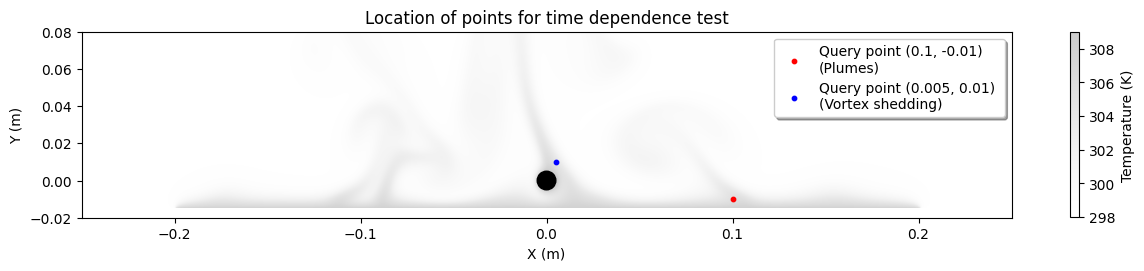

In [24]:
# Plot the sample grid above 
fig, ax = plt.subplots(figsize=(15,12))

#Clim = [np.min(T), np.max(T)]

# Create initial image
#ax.scatter(CellX, CellY, c='blue', label='Cell centroids')
p_ = ax.imshow(SI, extent=[XMIN, XMAX, YMIN, YMAX], cmap='Greys', alpha=0.2)

ax.set_ylim([YMIN, YMAX])
circle = plt.Circle((0, 0), 0.005, color='black', fill=True)
ax.add_patch(circle)

ax.scatter([0.1], [-0.01], s=10, c='red', label="Query point (0.1, -0.01) \n(Plumes)")
ax.scatter([0.005], [0.01], s=10, c='b', label="Query point (0.005, 0.01) \n(Vortex shedding)")
plt.colorbar(p_, ax=ax, label='Temperature (K)', shrink=0.2, )
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Location of points for time dependence test')
plt.legend(frameon=True, fancybox=True, shadow=True)

#plt.savefig('./points_For_mesh_time_Dep.pdf', dpi=300, bbox_inches='tight')

#plt.close()


# Start working with POST files

In [44]:
# Run through a sample post file's hierarchy
fname = DataFolder+"M4-1-02001-2002.dat.post"

# From https://stackoverflow.com/questions/43371438/how-to-inspect-h5-file-in-python
def scan_hdf52(path, recursive=True, tab_step=2):
    def scan_node(g, tabs=0):
        elems = []
        for k, v in g.items():
            if isinstance(v, h5py.Dataset):
                elems.append(v.name)
            elif isinstance(v, h5py.Group) and recursive:
                elems.append((v.name, scan_node(v, tabs=tabs + tab_step)))
        return elems
    with h5py.File(path, 'r') as f:
        return scan_node(f)
    

# Likely one per boundary - none for the internal fluid yet.
scan_hdf52(fname) #, recursive=True


[('/results',
  [('/results/1.post',
    [('/results/1.post/mixture',
      [('/results/1.post/mixture/nodes',
        ['/results/1.post/mixture/nodes/fields',
         ('/results/1.post/mixture/nodes/Static Temperature',
          ['/results/1.post/mixture/nodes/Static Temperature/1',
           '/results/1.post/mixture/nodes/Static Temperature/2',
           '/results/1.post/mixture/nodes/Static Temperature/3',
           '/results/1.post/mixture/nodes/Static Temperature/4',
           '/results/1.post/mixture/nodes/Static Temperature/5',
           '/results/1.post/mixture/nodes/Static Temperature/6',
           '/results/1.post/mixture/nodes/Static Temperature/7',
           '/results/1.post/mixture/nodes/Static Temperature/8']),
         ('/results/1.post/mixture/nodes/Wall Temperature',
          ['/results/1.post/mixture/nodes/Wall Temperature/1',
           '/results/1.post/mixture/nodes/Wall Temperature/2',
           '/results/1.post/mixture/nodes/Wall Temperature/3',
       

Looks like `/results/1.post/mixture/nodes/Static Temperature/1` may be the entire fluid... prove:

In [60]:
with h5py.File(fname, 'r') as f:
    temp = f['/results/1.post/mixture/nodes/Static Temperature/1'][:]

    casefile_For_this = f['/settings/Case File'][:][0].astype('str')

print(temp, "Number of nodes: ", np.array(temp).shape)
print(casefile_For_this)

[308.         307.92958276 307.92992862 ... 298.         298.
 298.        ] Number of nodes:  (235616,)
M4-1-02001-2002.cas.post


This looks correct - approx 200k values in the original h5 results. The post format appears to have its own unique case file... we need to get the cell centroids from this one instead and map it to the results above - NOTE: the post file itself does not have the same hierarchy as the h5 ones we were using prior

## Scan hierarchy of post casefile

In [65]:
casefile_post = DataFolder+casefile_For_this
print(scan_hdf52(casefile_post) )#, recursive=True

[('/meshes', [('/meshes/1.post', [('/meshes/1.post/nodes', [('/meshes/1.post/nodes/zoneTopology', ['/meshes/1.post/nodes/zoneTopology/id', '/meshes/1.post/nodes/zoneTopology/dimension', '/meshes/1.post/nodes/zoneTopology/maxId', '/meshes/1.post/nodes/zoneTopology/minId', '/meshes/1.post/nodes/zoneTopology/name', '/meshes/1.post/nodes/zoneTopology/zoneType', '/meshes/1.post/nodes/zoneTopology/fields']), ('/meshes/1.post/nodes/coords', ['/meshes/1.post/nodes/coords/1', '/meshes/1.post/nodes/coords/2', '/meshes/1.post/nodes/coords/3', '/meshes/1.post/nodes/coords/4', '/meshes/1.post/nodes/coords/5', '/meshes/1.post/nodes/coords/6', '/meshes/1.post/nodes/coords/7', '/meshes/1.post/nodes/coords/8'])]), ('/meshes/1.post/faces', [('/meshes/1.post/faces/zoneTopology', ['/meshes/1.post/faces/zoneTopology/id', '/meshes/1.post/faces/zoneTopology/dimension', '/meshes/1.post/faces/zoneTopology/maxId', '/meshes/1.post/faces/zoneTopology/minId', '/meshes/1.post/faces/zoneTopology/name', '/meshes/1.po

Below is a function in flux still - got caught in an issue with accessing face ids to cell id:

In [74]:
# GOAL: write a function that calculates cell centroids from cas.post files. 
# NOTE that normal case files have 4 members in the faces group <HDF5 group "/meshes/1/faces" (4 members)>, while cas.post files only have 2. <HDF5 group "/meshes/1.post/faces" (2 members)>
def get_cells_from_post_cas(casefile):
    """Obtains cell centroid coordinates from a casefile. 
    Takes vertex indices, maps vertices to faces, and maps faces to cells. 
    Cell centroids are obtained and one zval is ascribed to one cell centroid.
    """
    fname = os.path.join(DataFolder, casefile)

    with h5py.File(fname, 'r') as f:
        VertexList = f['/meshes/1.post/nodes/coords/1'][:].T  # Shape should be (2, N)
        FaceIdToVertexId = f['/meshes/1.post/faces/nodes/1/nodes'][:]  # Shape (M,)
        #FaceIdToCellId = np.array(f['/meshes/1.post/faces/c0/1'][:])  # Shape (M/2,)

        print(f['/meshes/1.post/faces/'])

    return #FaceIdToCellId

Problem: POST files don't have the c0 group...? prove:

In [84]:
# Debugging the post casefile
def print_group_contents(group, indent=0):
    """Recursively print the contents of an HDF5 group."""
    spacing = ' ' * indent
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{spacing}Group: {key}")
            print_group_contents(item, indent + 2)  # Recursive call for nested groups
        elif isinstance(item, h5py.Dataset):
            print(f"{spacing}Dataset: {key}, Shape: {item.shape}, Dtype: {item.dtype}")

# Open the HDF5 file
with h5py.File(casefile_post, 'r') as f:
    # Access the 'faces' group
    faces_group = f.get('/meshes/1.post/faces')
    
    if faces_group is not None:
        print("Contents of the 'faces' group:")
        print_group_contents(faces_group)
    else:
        print("The 'faces' group was not found in the file.")


Contents of the 'faces' group:
Group: zoneTopology
  Dataset: id, Shape: (7,), Dtype: int32
  Dataset: dimension, Shape: (7,), Dtype: uint64
  Dataset: maxId, Shape: (7,), Dtype: uint64
  Dataset: minId, Shape: (7,), Dtype: uint64
  Dataset: name, Shape: (1,), Dtype: |S59
  Dataset: childZoneId, Shape: (7,), Dtype: int32
  Dataset: faceType, Shape: (7,), Dtype: int32
  Dataset: shadowZoneId, Shape: (7,), Dtype: int32
  Dataset: zoneType, Shape: (7,), Dtype: int32
  Dataset: fields, Shape: (1,), Dtype: |S43
Group: nodes
  Group: 1
    Dataset: nnodes, Shape: (523,), Dtype: int16
    Dataset: nodes, Shape: (1046,), Dtype: uint32
  Group: 2
    Dataset: nnodes, Shape: (34,), Dtype: int16
    Dataset: nodes, Shape: (68,), Dtype: uint32
  Group: 3
    Dataset: nnodes, Shape: (34,), Dtype: int16
    Dataset: nodes, Shape: (68,), Dtype: uint32
  Group: 4
    Dataset: nnodes, Shape: (347,), Dtype: int16
    Dataset: nodes, Shape: (694,), Dtype: uint32
  Group: 5
    Dataset: nnodes, Shape: (34

In [87]:
# Debugging the original casefile
# Open the HDF5 file
with h5py.File(DataFolder+casefiles[0], 'r') as f:
    # Access the 'faces' group
    faces_group = f.get('/meshes/1/faces')
    
    if faces_group is not None:
        print("Contents of the 'faces' group:")
        print_group_contents(faces_group)
    else:
        print("The 'faces' group was not found in the file.")


Contents of the 'faces' group:
Group: c0
  Dataset: 1, Shape: (470096,), Dtype: uint32
Group: c1
  Dataset: 1, Shape: (467824,), Dtype: uint32
Group: nodes
  Group: 1
    Dataset: nnodes, Shape: (470096,), Dtype: int16
    Dataset: nodes, Shape: (940192,), Dtype: uint32
Group: zoneTopology
  Dataset: c0, Shape: (8,), Dtype: int32
  Dataset: c1, Shape: (8,), Dtype: int32
  Dataset: childZoneId, Shape: (8,), Dtype: int32
  Dataset: dimension, Shape: (8,), Dtype: uint64
  Dataset: faceType, Shape: (8,), Dtype: int32
  Dataset: fields, Shape: (1,), Dtype: |S56
  Dataset: flags, Shape: (8,), Dtype: int32
  Dataset: id, Shape: (8,), Dtype: int32
  Dataset: maxId, Shape: (8,), Dtype: uint64
  Dataset: minId, Shape: (8,), Dtype: uint64
  Dataset: shadowZoneId, Shape: (8,), Dtype: int32
  Dataset: zoneType, Shape: (8,), Dtype: int32


To conclude for now: the `cas.post` casefiles do not contain c0 and c1, while regular casefiles do. Can we still produce cell centroids from this?